# The Transformation and Accept/Reject (aka. Von Neumann) methods

Python notebook for illustrating how to generate random numbers following a specific PDF using uniformly distributed random numbers. Both the Accept-Reject (Von Neumann) and transformation methods are used.

### References:
- G. Cowan: Chapter 3
- P. R. Bevington: page 81-84
- __[40. Monte Carlo Techniques PDG](http://pdg.lbl.gov/2020/reviews/rpp2020-rev-monte-carlo-techniques.pdf)__

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 29-11-2022 (latest update)

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats

Load external functions:

In [2]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

set the parameters of the program:

In [3]:
r = np.random
r.seed(42)

save_plots = False   
N_points = 10000      # Number of random points to be produced!

xmin = 0.0
xmax = 1.0
N_bins = 100

# Define f(x) = 2x, for x in [0,1]
def fx_2x(x) :
    # Normalization is N_points * binwidth:
    k = (xmax - xmin) / N_bins
    N = N_points * k
    return N * 2*x

### Problem: Produce - using the TRANSFORMATION METHOD - random points following $f(x) = 2x, x \in [0, 1]$.

To produce random numbers according to $f(x)$ we use the transformation method:

$F(x) = x^2$ and then $F^{-1}(r) = \sqrt{r}$, where $r$ is uniform numbers in $[0,1]$

**NOTE: Remember that you have to think about limits!**

In [4]:
x_transformation = np.sqrt(r.uniform(size=N_points))

And to make sure that we have computed the points correctly, we plot a histogram of the data:

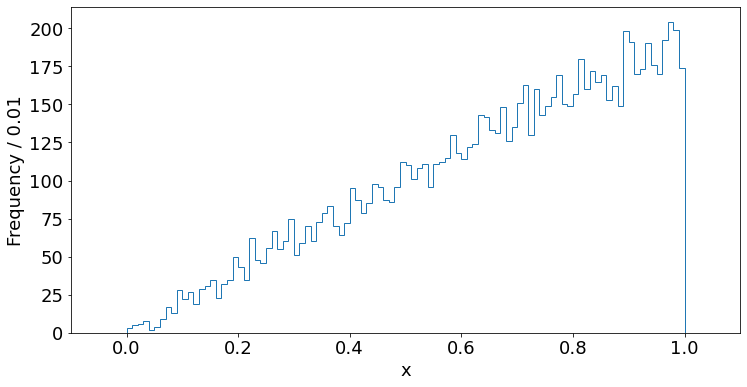

In [7]:
fig, ax = plt.subplots(figsize=(12, 6), facecolor = "white")
ax.hist(x_transformation, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax.set(xlabel="x", ylabel="Frequency / 0.01", xlim=(xmin-0.1, xmax+0.1));

And plot $f(x)$ on top of the figure (notice, no fit here!) along with the legend, figure text and finally saves the figure:

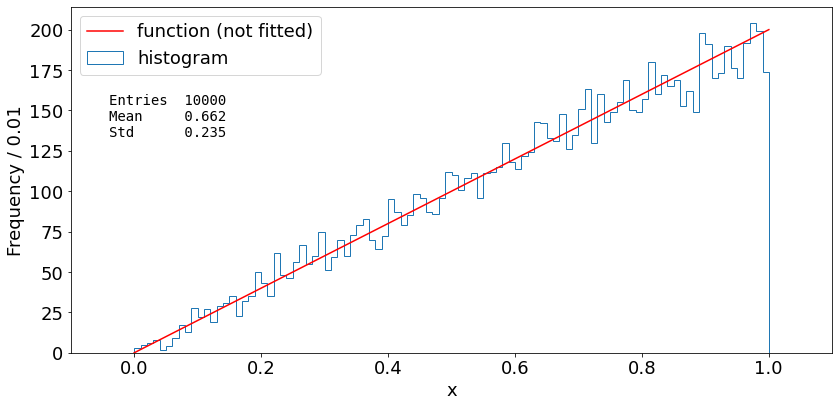

In [8]:
# Plot f(x)
x_axis1 = np.linspace(xmin, xmax, 1000)
y_axis1 = fx_2x(x_axis1)
ax.plot(x_axis1, y_axis1, 'r-', label='function (not fitted)')

# Define figure text
d = {'Entries': len(x_transformation),
     'Mean': x_transformation.mean(),
     'Std': x_transformation.std(ddof=1),
    }

# Plot figure text
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.05, 0.75, text, ax, fontsize=14)

# Add legend
ax.legend(loc='best')
fig.tight_layout()

# Save figure
if save_plots: 
    fig.savefig("Hist_2x_TransformationMethod.pdf", dpi=600)

# Show the figure
fig

And we see how we have succesfully generated random numbers according to $f(x)$ via the transformation method. Notice that if this method, if applicable, is 100% effective! 

### Problem: Produce - using the ACCEPT/REJECT METHOD - random points following $f(x) = 2x, x \in [0, 1]$.

To produce random numbers according to $f(x)$ we now use the accept/reject method.
Since this is bounded by $[0,1] \times [0,2]$, this is the range we generate numbers in.

To simulate the data we repeat the process, until the wanted number of points have been generated. A bit annoyingly, there is no do-while loop in Python, which explains the "funny" while construction below.

In [15]:
N_try = 0
ymin = 0.0      # Minimum value the function will take!
ymax = 2.0      # Maximum value the function will take!
N_points = 100000
x_accepted = np.zeros(N_points)

for i in range(N_points):
    
    while True:
        
        # Count the number of tries, to get efficiency/integral
        N_try += 1                    
        
        # Range that f(x) is defined/wanted in:
        x_test = r.uniform(xmin, xmax)  
        
        # Upper bound for function values:
        y_test = r.uniform(ymin, ymax)
        
        if (y_test < 2 * x_test):
            break
            
    x_accepted[i] = x_test

The Accept/Reject method is not $100%$ perfective, meaning that to generate $N$ random points according to $f(x)$ we have to loop $M > N$ times. Here the efficiency is defined as $\epsilon = N / M = $ `eff`:

In [16]:
# Efficiency
eff = N_points / N_try                        

# Error on efficiency (binomial!)
eff_error = np.sqrt(eff * (1-eff) / N_try) 

# Integral
integral =  eff * (xmax-xmin) * (ymax-ymin)

# Error on integral
eintegral = eff_error * (xmax-xmin) * (ymax-ymin)  

print(f"\nIntegral of f(x) = 2x, x in [0, 1] is: \t {integral:7.4f} +- {eintegral:6.4f}")
print(f"The efficiency of the Accept/Reject method used here is: \t {eff:.2%} +/- {eff_error:.2%}")
# We normalized the function ahead of time, so we should hope to get a result consistent with unity!


Integral of f(x) = 2x, x in [0, 1] is: 	  1.0002 +- 0.0022
The efficiency of the Accept/Reject method used here is: 	 50.01% +/- 0.11%


This allowed us to estimate the integral of $f(x)$. It was not hard, but it could have been much harder, and so the method allows one to estimate complicated integrals. As it turns out, this generalises to multiple dimensions, where other methods have a hard time.

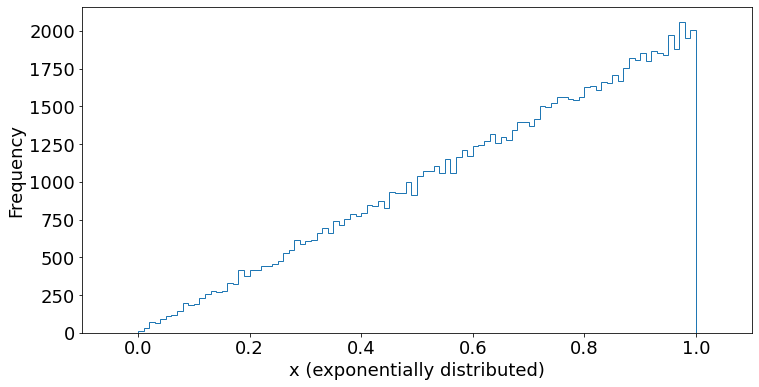

In [19]:
fig2, ax2 = plt.subplots(figsize=(12, 6), facecolor = "white")
ax2.hist(x_accepted, bins=N_bins, range=(xmin, xmax), histtype='step', label='histogram' )
ax2.set(xlabel="x (exponentially distributed)", ylabel="Frequency", xlim=(xmin-0.1, xmax+0.1));

And plot $g(x)$ on top of the figure (notice, no fit here!) along with the legend, figure text and finally saves the figure:

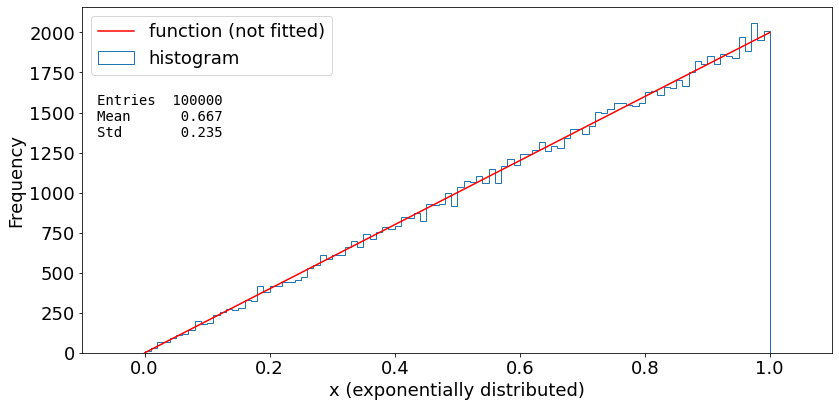

In [20]:
# Plot f(x)
x_axis2 = np.linspace(xmin, xmax, 1000)
y_axis2 = fx_2x(x_axis2)
ax2.plot(x_axis2, y_axis2, 'r-', label='function (not fitted)')

# Define the figure text
d2 = {'Entries': len(x_accepted),
      'Mean': x_accepted.mean(),
      'Std': x_accepted.std(ddof=1),
    }

# Add figure text
text2 = nice_string_output(d2, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.75, text2, ax2, fontsize=14)

# Add legend
ax2.legend(loc='best')
fig2.tight_layout()

# Save figure
if save_plots: 
    fig2.savefig("Hist_2x_AcceptRejectMethod.pdf", dpi=600)
    
# Show the figure
fig2

This exercise was simply to illustrate how to use the two methods. Next, you should try to apply the two methods yourself on slightly more complicated functions, which is what the following two exercises is about:
- TransformationAcceptReject_pol3.ipynb: Try the two methods on a third degree polynomial.
- TransformationAcceptReject_general.ipynb: Try the two methods on three different problems.

The learning points are in the next exercise (TransformationAcceptReject_pol3.ipynb)!

# Questions
1. How would you test, if the two histograms with numbers from transformation and accept/reject methods are statistically the same? There are many methods, but you should at least be able to think of one way.